In [1]:
import sys

sys.path.append("../berries")


In [2]:
from my_datasets import load_supervised_1d

#n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised_1d("fashion_mnist")
n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised_1d("mnist")

/home/owner/Projects/picojam/pico/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
X = X / 255.0
X_test = X_test / 255.0

In [12]:
d_h_layer = 256
d_h = 256
n_layers = 1
d_in = d_x
# d_out = d_y
d_out = d_x
d_code = 64
total_codes = 2048
sentence_len = 64
beta = 0.25

In [22]:

import nn
import importlib
importlib.reload(nn)
from nn import mglu_net_config, mglu_net, rmglu_net
# import pf
# importlib.reload(pf)
from pf import F, _

from jax.numpy import mean, exp
from jax.lax import stop_gradient


# def vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, init):
#     return {
#         "encoder":mglu_net_config(d_in, d_h_layer, 2 * d_vae_h, d_h, n_layers, init),
#         "decoder": mglu_net_config(d_vae_h, d_h_layer, d_in, d_h, n_layers, init)}

def vqvae_config(init):
    return {
        "codebook": {
            "size": (total_codes, d_code),
            "init": init
        },
        "encoder": mglu_net_config(d_x, d_h_layer, sentence_len*d_code, d_h, n_layers, init),
        "decoder": mglu_net_config(sentence_len*d_code, d_h_layer, d_x, d_h, n_layers, init)
    }



def nearest_code(codebook, z):
    return codebook[((z - codebook) ** 2).sum(1).argmin(0)]



def vqvae(W, x):
    z = mglu_net(x, W["encoder"])
    # z shape is (sentence_len * d_code,)
    z = z.reshape((sentence_len, d_code))
    z_q = F(nearest_code).f(W['codebook'], _).map()(z)
    x_q = mglu_net(z_q.reshape(-1), W["decoder"])
    return x_q, z, z_q

def vqvae_losses(W, x):
    x_q, z, z_q = vqvae(W, x)
    rec_loss = ((x_q - x) ** 2).mean()
    codebook_loss = ((stop_gradient(z_q) - z) ** 2).mean()
    commitment_loss = 0.25 * ((z - stop_gradient(z_q)) ** 2).mean()
    return rec_loss + codebook_loss + commitment_loss, rec_loss, codebook_loss, commitment_loss



loss_b = F(vqvae_losses)[0].vmap((None, 0), 0)
loss_bm = loss_b >> mean


In [6]:
# test neareset code
import init_utils
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)


In [23]:
import optax
from jax import grad, jit
from jax.tree_util import tree_map
from nn import init_weights, fmt_weights



lr = 0.001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.rmsprop(lr), mask_fn)

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.1, shape=[size, d_x])

method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
# method = {"type": "normal", "std": 0.1}
W = init_weights(next(key_gen), vqvae_config(method))
print(fmt_weights(W)[0])
loss0 = loss_bm(W, X_test[:100, :])
print(loss0)
state = opt.init(W)

@jit
def update(W, x, opt_state):
    grads = grad(loss_bm)(W, x)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

codebook:
    array shape: (2048, 64)
encoder:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (784, 256)
                wu:
                    array shape: (784, 256)
                wo:
                    array shape: (256, 256)
                total params: 466944
            rmsn:
                d:
                    256.0
                total params: 1
            total params: 466945
        tuple:
            sglu:
                wv:
                    array shape: (256, 256)
                wu:
                    array shape: (256, 256)
                wo:
                    array shape: (256, 256)
                total params: 196608
            rmsn:
                d:
                    256.0
                total params: 1
            total params: 196609
        total params: 663554
    sglu:
        wv:
            array shape: (256, 256)
        wu:
            array shape: (256, 256)
        wo:
            arra

AttributeError: 'PointFreeFunction' object has no attribute 'reshape'

98.03434 97.20962


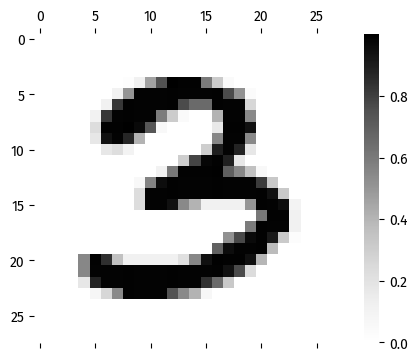

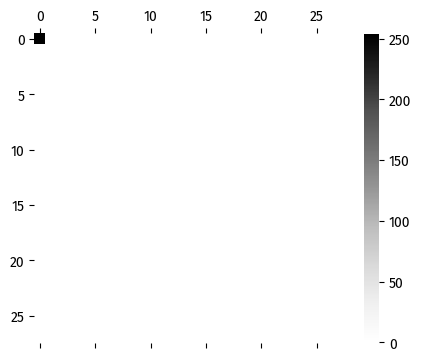

0.069014445 0.06550205
0.07107718 0.06676277
0.07003317 0.06478077
0.068368375 0.06490096
0.06719233 0.06544574


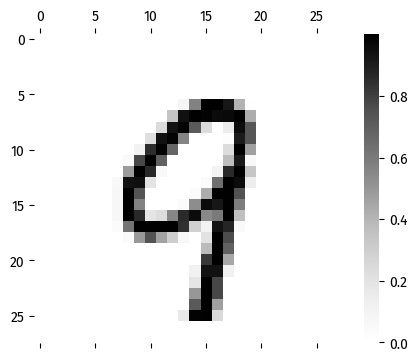

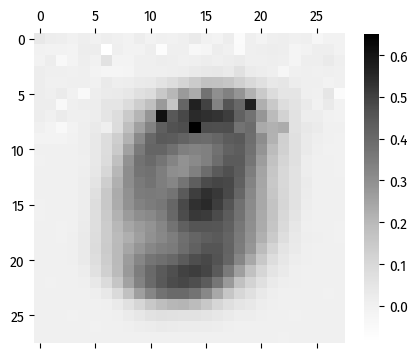

0.06735985 0.065042846
0.06610865 0.064932965
0.068073675 0.064636655
0.0684064 0.064727254
0.064981505 0.06464378


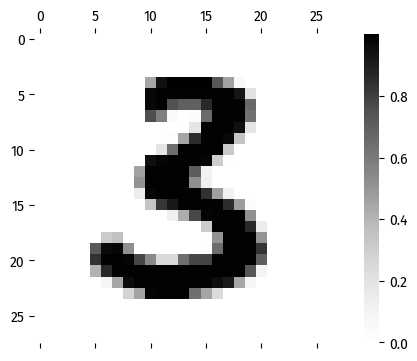

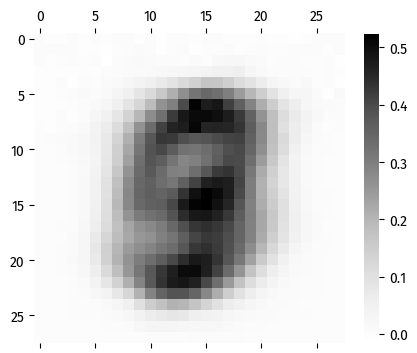

0.067114264 0.064610176
0.06966658 0.065363534
0.06800409 0.065250985
0.06777847 0.0652956
0.06522408 0.06478879


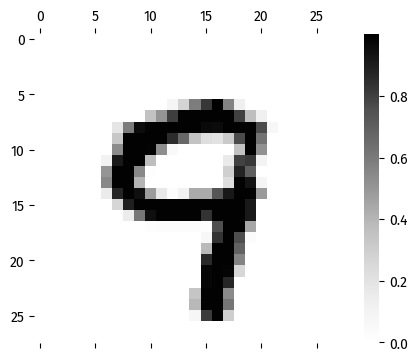

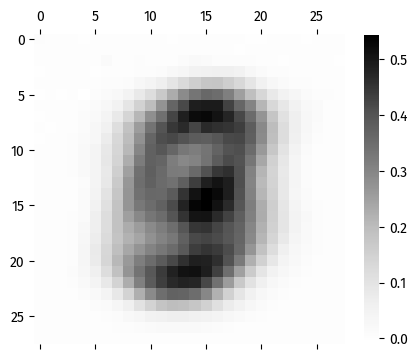

0.06709449 0.06470641
0.06573476 0.06468481
0.06827067 0.06502144
0.06604698 0.06496601
0.06809577 0.06501504


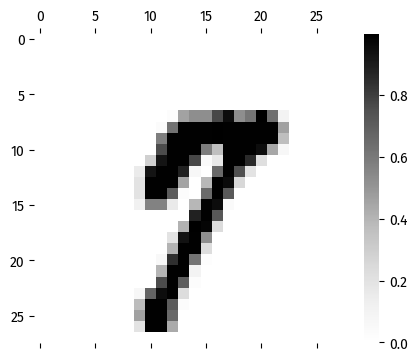

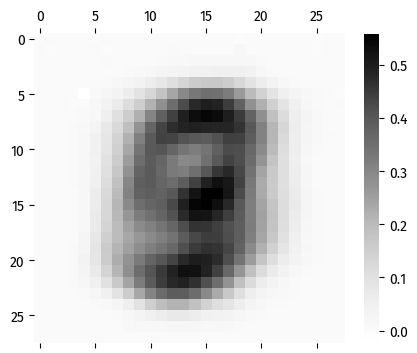

0.06712809 0.065843344
0.0668591 0.064679086
0.06705307 0.064558275
0.066608965 0.064769655
0.06476054


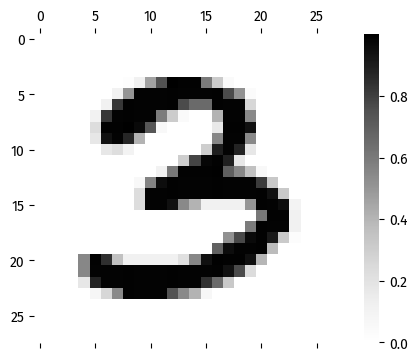

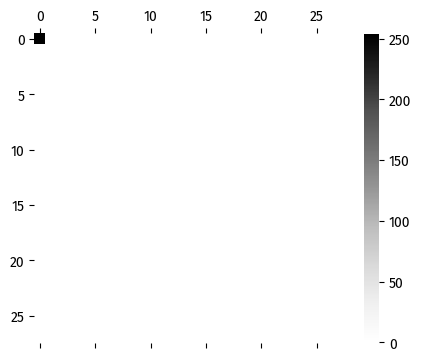

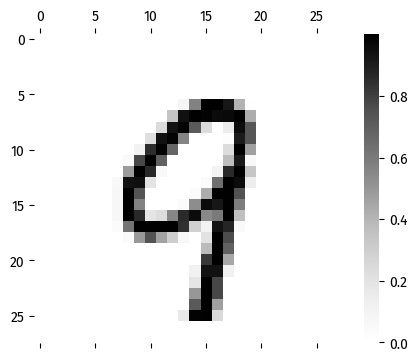

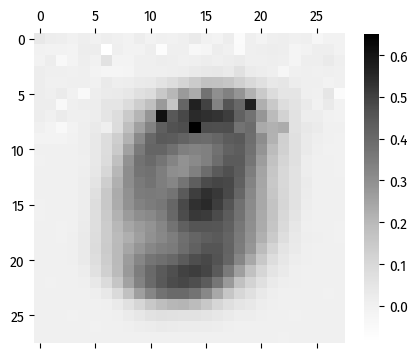

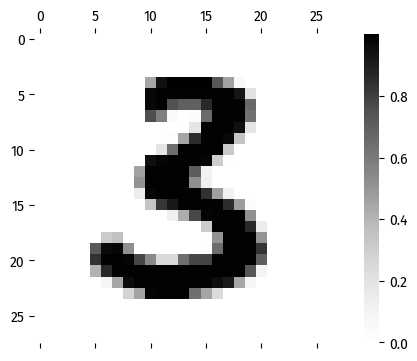

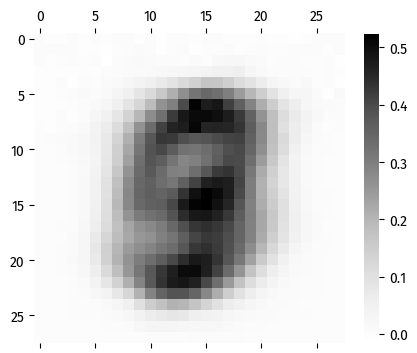

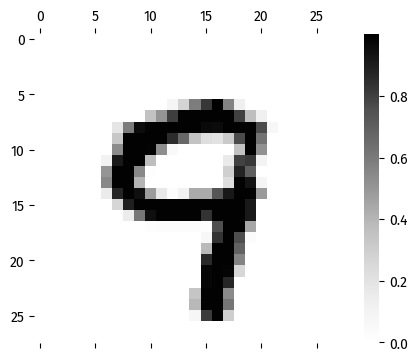

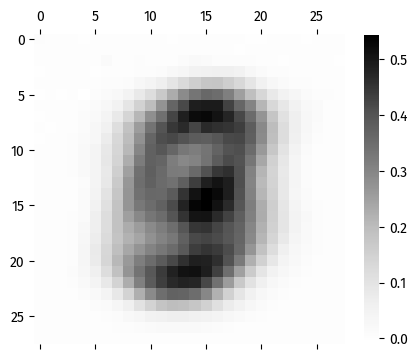

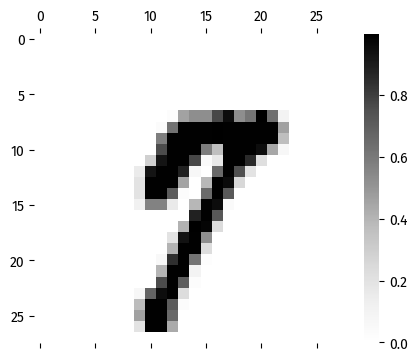

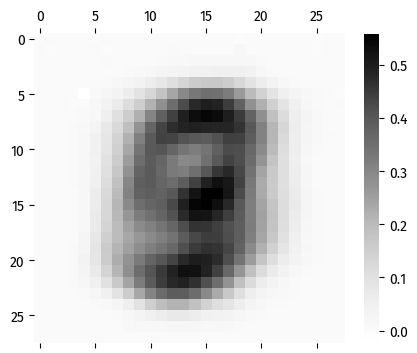

In [11]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random
import jax.numpy as np


def loss_b_dt(W):
    return mean(loss_b(W, X_test[:100, :]))


batch_size = 256

def sample():
    return X[random.sample(range(n_samples), batch_size), :]

for i in range(5000):
    key = next(key_gen)
    data = sample()
    W, state = update(W, data, state)
    if i % 200 == 0:
        print(loss_bm(W, data), loss_b_dt(W))
    if i % 1000 == 0:
        image_id = math.ceil(random.uniform(0, 1) * n_samples)
        plt, __, __ = visualize_matrix(data[image_id, :].reshape(28, 28), dpi=100)
        display(plt)

        out = vqvae(W, data[image_id, :])[0]
        plt, __, __ = visualize_matrix(out.reshape(28, 28), dpi=100)
        display(plt)


print(loss_b_dt(W))
